[0 1 1 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1 1 1 0 0 1 1 0 1 1 1 0 1 0 0]


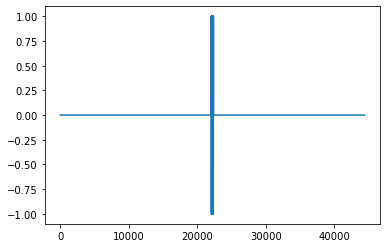

Fichier WAV créé : signal.wav


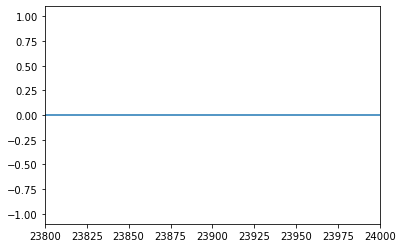

In [188]:
import comnumfip2_modif as com
import numpy as np
from scipy.io.wavfile import write
from importlib import reload 
import matplotlib.pyplot as plt
reload(com)
message = "test"
signal = com.NRZ_signal_generator(message)


com.plot_signal(signal)
com.send_signal_to_canal(signal)


# Paramètres du signal
freq_echantillonnage = 44100  # Fréquence d'échantillonnage en Hz


# Écrire le signal dans un fichier WAV
nom_fichier = "signal.wav"
write(nom_fichier, freq_echantillonnage, signal)
print(f"Fichier WAV créé : {nom_fichier}")


plt.figure()
plt.plot(signal)
plt.xlim(23800,24000)
plt.show()


44420


(0.495, 0.52)

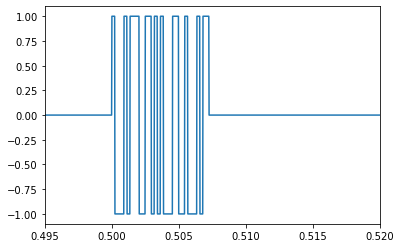

In [195]:
print(len(signal))
n = np.arange(0,len(signal))/44100
plt.plot(n,signal)
plt.xlim(0.495,0.52)


Decodage du signal

In [ ]:
import wave
import matplotlib.pyplot as plt
import numpy as np

# Ouvrir le fichier wave en mode lecture
nom_fichier = "pasdepb.wav"  # Remplacez cela par le nom de votre propre fichie21900r wave
with wave.open(nom_fichier, 'rb') as fichier_wave:
    # Obtenir les propriétés du fichier wave
    nb_channels = fichier_wave.getnchannels()
    sample_width = fichier_wave.getsampwidth()
    framerate = fichier_wave.getframerate()
    nb_frames = fichier_wave.getnframes()

    # Lire les données audio
    frames = fichier_wave.readframes(nb_frames)

    # Convertir les données binaires en valeurs d'échantillons
    # en fonction de la largeur de l'échantillon
    if sample_width == 1:
        # Pour les échantillons de 8 bits (unsigned)
        samples = np.frombuffer(frames, dtype=np.uint8)
    elif sample_width == 2:
        # Pour les échantillons de 16 bits (signed)
        samples = np.frombuffer(frames, dtype=np.int16)
    elif sample_width == 4:
        # Pour les échantillons de 32 bits (float)
        samples = np.frombuffer(frames, dtype=np.float32)
    else:
        raise ValueError("Largeur d'échantillon non prise en charge : {}".format(sample_width))

    # Créer un tableau de temps en secondes pour les échantillons
    temps = np.arange(0, nb_frames) / framerate

    # Afficher les données audio dans un graphique
    plt.figure(figsize=(12, 6))
    plt.plot(samples)
    plt.xlabel('Temps (s)')
    plt.ylabel('Amplitude')
    plt.title('Données audio')
    plt.show()

In [ ]:
plt.figure()
plt.xlim(32000,32100)
plt.plot(samples)
plt.show()


In [ ]:
#tracer le spectre du signal

# Calcul de la FFT sur le signal recu
plt.figure()
plt.plot(samples)
plt.show()


FFT = np.fft.fft(samples)
MOD_FFT=np.abs(FFT)
Pha_FFT=np.angle(FFT)

# centrage de la transformé et shift
Fe = 44100 
Te= 1/Fe
N = len(samples)
k= np.arange(N) -np.floor(N/2)  # np floor permet d'avoir une valeur arrondie et le - va faire un décalage vectoriel
MOD_FFT = np.fft.fftshift(MOD_FFT)
Pha_FFT = np.fft.fftshift(Pha_FFT)

f = k/(N*Te)


#affichage de la phase
plt.figure(figsize=(10,5))
plt.ylabel("Phase")
plt.xlabel("f(HZ)")
plt.plot(f,Pha_FFT)

#affichage du module
plt.figure(figsize=(10,5))
plt.ylabel("Module")
plt.xlabel("f(HZ)")
plt.plot(f,MOD_FFT)

In [ ]:
#filtrage du signal par un filtre RIF
#on veut filtrer les hautes fréquence donc il faut un filtre passe bas

fe = 44100
#On commence par définir se que l'on connait

fc1 = 1000       #frequence de coupure
fc2 = 22100
df = 100        #largueur de bande
Ondbande = 1    #ondulation en bande passante
stopband = -60  # atténuation en stop bande

# Abscisses des 4 points de la ligne brisée
x1 = [0, fc1 - df/2, fc1 - df/2, fc1 - df/2]

# Ordonnées des 4 points de la ligne brisée
y1 = [stopband,stopband, Ondbande, Ondbande]

# Abscisses des 4 points de la ligne brisée
x2 = [fc2+df/2,fc2+df/2, fe/2, fe/2]

# Ordonnées des 4 points de la ligne brisée
y2 = [Ondbande,stopband, stopband,  stopband]


# Abscisses des 4 points de la ligne brisée
x3 = [fc1+df/2,fc1+df/2, fc2-df/2, fc2-df/2]

# Ordonnées des 4 points de la ligne brisée
y3 = [stopband,-Ondbande, -Ondbande,  stopband]

# Affichage
plt.figure(figsize=(20,5))
plt.plot(x1, y1, color='k', linestyle='--', marker='*')
plt.plot(x2, y2, color='k', linestyle='--', marker='*')
plt.plot(x3, y3, color='k', linestyle='--', marker='*')
plt.xlabel("f (Hz)")
plt.ylabel("20 log|H| (dB)")
plt.title('gabarit')
plt.show()



In [ ]:

largeur_de_transition = (fc1+df-fc1) / fe
print("Ordre des fenêtres (déterminé à partir de la largeur de transition) :")
print(f"Blackmann :            N = {int(5.5/largeur_de_transition)}")
print(f"Kaiser (beta = 6,76) : N = {int(4.32/largeur_de_transition)}")
print(f"Kaiser (beta = 8,96) : N = {int(5.71/largeur_de_transition)}")



#Synthétisation du filtre RIF
from scipy import signal
#scipy.signal.firwin(numtaps, cutoff, width=None, window='hamming', pass_zero=True, scale=True, nyq=None, fs=None)
N = int(4.32/largeur_de_transition)
print(N)

rif = signal.firwin(N,fc1,window=("kaiser", (6.76)),fs=fe,pass_zero='highpass')
#rif = signal.firwin(N,(fc1,fc2),window=("kaiser", (6.76)),fs=fe,pass_zero='bandpass') #ici, la fréquence de coupure a été ajusté à la main (à la base c'était 0.5) à cause des erreurs numérique
w, h = signal.freqz(rif,fs=fe) #w retourne Les fréquences auxquelles h a été calculé, dans les mêmes unités que fs. (fe/2)
                                #h La réponse en fréquence, sous forme de nombres complexes.
plt.figure(figsize=(20,5))       
plt.plot(w,20 * np.log10(abs(h))) #on fait alors 20 log de l'absolue de h pour avoir le module qu'on affiche en fonction de w
plt.plot(x1, y1, color='k', linestyle='--', marker='*')
plt.plot(x2, y2, color='k', linestyle='--', marker='*')
plt.plot(x3, y3, color='k', linestyle='--', marker='*')
plt.xlabel("f (Hz)")

plt.ylabel("20 log|H| (dB)")
plt.show()


#analyse du retard de groupe
w, gd = signal.group_delay((rif,1))
plt.figure()
plt.ylabel('retard de groupe (échantillions)')
plt.plot(w,gd)
plt.show()
print(gd[0])

In [ ]:

samples_rif_filtered = signal.lfilter(rif,1,samples)
plt.figure()
plt.plot(samples_rif_filtered)
plt.title("signal filtered")
plt.show()
samples_rif_filtered = samples_rif_filtered[(samples_rif_filtered > 20000) | (samples_rif_filtered < -20000)]

plt.figure()
plt.plot(samples_rif_filtered)
plt.show()


bin=com.sample_and_threshold(samples_rif_filtered,10000)
print(bin)

bin = bin[1:]
print(len(bin))
print(com.bin2ascii(bin))
